# Adult Income – Feature Engineering 検討・試行

## 目的

PCAおよび Logistic Regression の構造解析結果を踏まえ、
Adult Income データに対する特徴量エンジニアリング（FE）を設計・検証する。

FE候補の効果は LGBM を評価軸とし、
交差検証（CV）により性能および安定性を確認する。

有力な特徴量候補については補助的可視化を行い、
モデル挙動および誤分類傾向を把握する。

## 目次

1. データ読み込み・前処理
2. ベースラインモデル確認（LGBM）
3. FE設計方針
4. FE逐次検証（CV評価）
5. 有力FE候補の補助可視化
6. 考察

## 1. データ読み込み・前処理

In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# --- プロジェクトルート検出（最優先）---
ROOT = Path.cwd()
while not (ROOT / "data").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

# --- src imports（必ず後）---
from src.lgbm import preprocess, train_model
from src.feature_engineering import evaluate_cv


# --- 再現性 ---
np.random.seed(42)

# --- データ ---
RAW_TRAIN = ROOT / "data/raw/adult.data"
X, y, feature_cols = preprocess(RAW_TRAIN)

# --- 型安定化 ---
y_np = y.to_numpy() if isinstance(y, pd.Series) else np.asarray(y)
y_np = y_np.astype(np.int32)


## 2. ベースラインモデル確認（LGBM）

Adult Income データに対する LGBM ベースラインモデルの性能および可視化結果は、
別ノートブックにて検証済みである。

交差検証では高いAUCと安定性が確認され、
代表モデルの可視化からは、正例が少数派である分布構造および、
誤分類が特定の単一特徴量に偏らず散在する傾向が観察された。

これらの結果を前提とし、
本ノートブックでは Feature Engineering による性能変化および
モデル挙動の変化の検証に焦点を当てる。

## 3. FE設計方針

PCAおよびLogistic Regression による構造解析結果から、
本データは多因子的分散構造を持ち、特定変数への極端な依存は限定的であることが確認された。

主成分分析では、分散は複数成分へ分配され、
education-num、hours-per-week、capital-gain、age などが
統合的に寄与する構造を示した。

Logistic Regression では、capital-gain が最も強い寄与を持ち、
ゼロ集中およびロングテール分布が確認された。
また、誤分類は特定単変数に集中せず散在した。

これらの観察に基づき、
本ノートブックでは以下の特徴量エンジニアリングを検証対象とする：

- 分布歪み補正を目的とした単調変換
- ゼロ集中構造を反映するしきい値特徴量
- 条件依存効果を想定した限定的な交互作用

FE候補の有効性は、
LGBM を評価軸とした交差検証により確認する。

## 4. FE逐次検証（CV評価）

本セクションでは、ベースラインモデルを前提として、
特徴量を 1つずつ追加し、交差検証（StratifiedKFold）により性能変化を確認する。

評価は平均AUCと標準偏差を用い、
改善が確認できた候補のみを有力案として保持する。

### 4.1 分布歪み補正を目的とした単調変換

Logistic Regression および PCA による構造解析から、
capital-gain および capital-loss は
ゼロ集中およびロングテール分布を示すことが確認された。

これらの分布歪みは、
モデルの安定性および判別境界形成に影響を与える可能性がある。

そこで本節では、
分布の圧縮および極端値影響の緩和を目的として、
以下の単調変換特徴量を検証対象とする：

- log1p(capital-gain)
- log1p(capital-loss)

各特徴量は逐次追加とし、
交差検証（StratifiedKFold）による性能変化を評価する。

#### 4.1.1 log1p(capital-gain)

capital-gain はゼロ集中およびロングテール分布を示す。
分布圧縮と極端値影響の緩和を目的として
log1p(capital-gain) を導入する。

本特徴量を追加し、
交差検証により性能変化を評価する。

In [3]:
# log1p(capital-gain) 追加

X_fe = X.copy()
X_fe["capital-gain_log"] = np.log1p(X_fe["capital-gain"])

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")

Early stopping, best iteration is:
[301]	valid_0's auc: 0.923839	valid_0's binary_logloss: 0.28728
CV AUC mean = 0.922260
std         = 0.001891


log1p(capital-loss) を導入したが、
CV AUC に有意な変化は見られなかった。

本変換は分類性能の改善には寄与しないことが確認された。

### 4.1.2 log1p(capital-loss)

capital-loss もまた、ゼロ集中および歪んだ分布を示す特徴量である。
分布圧縮および極端値影響の緩和を目的として
log1p(capital-loss) を導入する。

本特徴量を追加し、
交差検証により性能変化を評価する。

In [4]:
# log1p(capital-loss) 追加

X_fe = X.copy()
X_fe["capital-loss_log"] = np.log1p(X_fe["capital-loss"])

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")



Early stopping, best iteration is:
[245]	valid_0's auc: 0.923917	valid_0's binary_logloss: 0.286935
CV AUC mean = 0.922394
std         = 0.001781


log1p(capital-loss) を導入したが、
CV AUC および標準偏差に有意な変化は見られなかった。

本変換はモデル性能改善には寄与しないことが確認された。

### 4.2 ゼロ集中構造を反映するしきい値特徴量

capital-gain および capital-loss は、
ゼロ値に観測が集中する分布特性を持つ。

このような特徴量では、
数値の大小よりも「発生の有無」が
判別構造に影響する可能性がある。

そこで本節では、
ゼロ集中構造を明示的に表現するため、
しきい値に基づく二値特徴量（flag特徴量）を導入する。

本特徴量は以下で定義される：

- capital-gain_flag = 1(capital-gain > 0)

- capital-loss_flag = 1(capital-loss > 0)

これにより、
収益／損失の発生有無を独立に評価可能とする。

#### 4.2.1 capital-gain_flag = 1(capital-gain > 0)

capital-gain はゼロ値への集中が支配的である。
このため、数値の大小ではなく
「収益発生の有無」を明示化する。

本節では次の二値特徴量を導入する：

capital-gain_flag = 1(capital-gain > 0)

本特徴量の性能寄与を CV により評価する。

In [5]:
# capital-gain_flag 追加

X_fe = X.copy()
X_fe["capital-gain_flag"] = (X_fe["capital-gain"] > 0).astype(np.int8)

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")

Early stopping, best iteration is:
[324]	valid_0's auc: 0.923558	valid_0's binary_logloss: 0.287342
CV AUC mean = 0.922141
std         = 0.001787


capital-gain_flag を導入したが、
CV AUC に有意な変化は見られなかった。

収益発生有無の明示化は、
単独では分類性能改善に寄与しないことが確認された。

#### 4.2.2 capital-loss_flag = 1(capital-loss > 0)

capital-loss はゼロ値への集中が支配的である。
このため、「損失発生の有無」を明示化する。

本節では次の二値特徴量を導入する：

capital-loss_flag = 1(capital-loss > 0)

本特徴量の性能寄与を CV により評価する。

In [6]:
# capital-loss_flag 追加

X_fe = X.copy()
X_fe["capital-loss_flag"] = (X_fe["capital-loss"] > 0).astype(np.int8)

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")


Early stopping, best iteration is:
[324]	valid_0's auc: 0.923571	valid_0's binary_logloss: 0.287399
CV AUC mean = 0.922140
std         = 0.001935


capital-loss_flag を導入したが、
CV AUC に有意な変化は見られなかった。

損失発生有無の明示化は、
単独では分類性能改善に寄与しないことが確認された。

### 4.3 交互作用

単一特徴量の変換（log・flag）では
性能改善は限定的であった。

PCA負荷量および Logistic Regression 係数の分析より、
capital-gain、education-num、hours-per-week は
判別構造に主要な寄与を持つことが確認されている。

また、誤分類分布の観察から、
誤差は単変数では説明困難であり、
特徴量間の組み合わせ効果が示唆される。

そこで本節では、
主要寄与特徴量間の関係性を明示化するため、
交互作用特徴量を導入する。

本変換は次で定義される：

特徴量A × 特徴量B

以降、PCAおよびLRで寄与が確認された
主要NUM_COLSの組み合わせを対象に
性能寄与を評価する。

#### 4.3.1 gain × education-num

PCA負荷量および Logistic Regression 係数より、
capital-gain と education-num は
主要な判別寄与を持つ特徴量である。

両変数の組み合わせ効果を明示化するため、
次の交互作用特徴量を導入する：

capital-gain × education-num

本特徴量の性能寄与を CV により評価する。

In [7]:
# capital-gain × education-num

X_fe = X.copy()
X_fe["gain_x_edu"] = X_fe["capital-gain"] * X_fe["education-num"]

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")


Early stopping, best iteration is:
[350]	valid_0's auc: 0.923877	valid_0's binary_logloss: 0.287059
CV AUC mean = 0.922288
std         = 0.001807


capital-gain × education-num を導入したが、
CV AUC に有意な変化は見られなかった。

本交互作用特徴量は
分類性能改善には寄与しないことが確認された。

#### 4.3.2 capital-gain × hours-per-week

PCAおよび Logistic Regression の分析より、
capital-gain と hours-per-week は
主要な判別寄与を持つ特徴量である。

両変数の組み合わせ効果を検証するため、
次の交互作用特徴量を導入する：

capital-gain × hours-per-week

本特徴量の性能寄与を CV により評価する。

In [8]:
# capital-gain × hours-per-week

X_fe = X.copy()
X_fe["gain_x_hours"] = X_fe["capital-gain"] * X_fe["hours-per-week"]

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")

Early stopping, best iteration is:
[293]	valid_0's auc: 0.923592	valid_0's binary_logloss: 0.287453
CV AUC mean = 0.922168
std         = 0.001673


capital-gain × hours-per-week を導入したが、
CV AUC に有意な変化は見られなかった。

本交互作用特徴量は
分類性能改善には寄与しないことが確認された。

#### 4.3.3 education-num × hours-per-week

PCA負荷量および Logistic Regression 係数より、
education-num と hours-per-week は
主要な判別寄与を持つ特徴量である。

人的資本と労働投入の組み合わせ効果を検証するため、
次の交互作用特徴量を導入する：

education-num × hours-per-week

本特徴量の性能寄与を CV により評価する。

In [9]:
# education-num × hours-per-week

X_fe = X.copy()
X_fe["edu_x_hours"] = X_fe["education-num"] * X_fe["hours-per-week"]

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")

Early stopping, best iteration is:
[301]	valid_0's auc: 0.92349	valid_0's binary_logloss: 0.287791
CV AUC mean = 0.922199
std         = 0.001864


education-num × hours-per-week を導入したが、
CV AUC に有意な変化は見られなかった。

本交互作用特徴量は
分類性能改善には寄与しないことが確認された。

#### 4.3.4 交互作用特徴量 全探索

In [10]:
from itertools import product

NUM_COLS = ["age","education-num","capital-gain","capital-loss","hours-per-week"]

results = []

for c1, c2 in product(NUM_COLS, repeat=2):

    X_fe = X.copy()
    X_fe[f"{c1}_x_{c2}"] = X_fe[c1] * X_fe[c2]

    mean_auc, std_auc = evaluate_cv(
        train_model,
        X_fe,
        y_np
    )

    results.append((c1, c2, mean_auc, std_auc))

# 表示
for r in results:
    print(f"{r[0]} × {r[1]} → AUC={r[2]:.6f}, std={r[3]:.6f}")



Early stopping, best iteration is:
[443]	valid_0's auc: 0.923743	valid_0's binary_logloss: 0.287142
age × age → AUC=0.922052, std=0.001740
age × education-num → AUC=0.921700, std=0.001944
age × capital-gain → AUC=0.922225, std=0.001719
age × capital-loss → AUC=0.922289, std=0.001953
age × hours-per-week → AUC=0.921643, std=0.001805
education-num × age → AUC=0.921700, std=0.001944
education-num × education-num → AUC=0.922233, std=0.001753
education-num × capital-gain → AUC=0.922288, std=0.001807
education-num × capital-loss → AUC=0.922312, std=0.001865
education-num × hours-per-week → AUC=0.922199, std=0.001864
capital-gain × age → AUC=0.922225, std=0.001719
capital-gain × education-num → AUC=0.922288, std=0.001807
capital-gain × capital-gain → AUC=0.922260, std=0.001891
capital-gain × capital-loss → AUC=0.922214, std=0.001467
capital-gain × hours-per-week → AUC=0.922168, std=0.001673
capital-loss × age → AUC=0.922289, std=0.001953
capital-loss × education-num → AUC=0.922312, std=0.0018

NUM_COLS を対象に交互作用特徴量を全探索したが、
CV AUC に有意な改善は確認されなかった。

本結果から、交互作用特徴量の導入は
分類性能改善には寄与しないことが示された。

### 5. 有力FE候補の補助可視化

セクション4において各種特徴量設計を検証した結果、
CV性能に対する顕著な改善は確認されなかった。

その中で、平均AUCが最も高い値を示した
特徴量変換の組み合わせを有力候補として選定する。

本章では、当該特徴量セットを導入したモデルについて、
予測挙動および誤分類傾向を補助的に可視化し、
性能評価だけでは把握しにくい構造的特性を確認する。

本可視化は、最終モデル決定を目的とするものではなく、
特徴量設計が分類構造へ与える影響の理解を目的とする。

#### 5.1 CV評価

In [11]:
# log1p(capital-loss) + (capital-loss)^2 → train_model基準CV

X_fe = X.copy()

X_fe["capital-loss_log"] = np.log1p(X_fe["capital-loss"])
X_fe["capital-loss_sq"]  = X_fe["capital-loss"] ** 2

mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")


Early stopping, best iteration is:
[307]	valid_0's auc: 0.92433	valid_0's binary_logloss: 0.286283
CV AUC mean = 0.922397
std         = 0.001957


log1p(capital-loss) および capital-loss² を導入した結果、
CV AUC はわずかに上昇した。

一方で標準偏差は増加し、
性能安定性の改善は確認されなかった。

本特徴量セットは、
平均性能に対する寄与は限定的である。

In [12]:
# --- 特徴量エンジニアリングベースライン ---
X_fe = X.copy()

# 1. カテゴリ交互作用（LRで線形寄与が小さいがLGBMで効いた組み合わせを追加）
#    例: education × occupation
X_fe["edu_occ"] = (
    X_fe["education"].astype(str)
    + "_"
    + X_fe["occupation"].astype(str)
).astype("category")

# 2. 数値特徴量そのまま保持（LRでcoefが大きい変数）
#    capital-gain, hours-per-week, age, capital-loss, education-num など
#    → すでに X に含まれているので追加作業不要

# 3. CV評価（train_model 基準）
mean_auc, std_auc = evaluate_cv(
    train_model,
    X_fe,
    y_np
)

print(f"CV AUC mean = {mean_auc:.6f}")
print(f"std         = {std_auc:.6f}")


Early stopping, best iteration is:
[298]	valid_0's auc: 0.923469	valid_0's binary_logloss: 0.287666
CV AUC mean = 0.921980
std         = 0.001674


#### 5.2 予測・評価可視化ブロック（予測確率ヒストグラム、ROC Curve、Confusion Matrix）

代表モデルについて、
予測確率ヒストグラム・ROC Curve・Confusion Matrix を可視化し、
予測分布・識別性能・分類結果の構造を確認する。

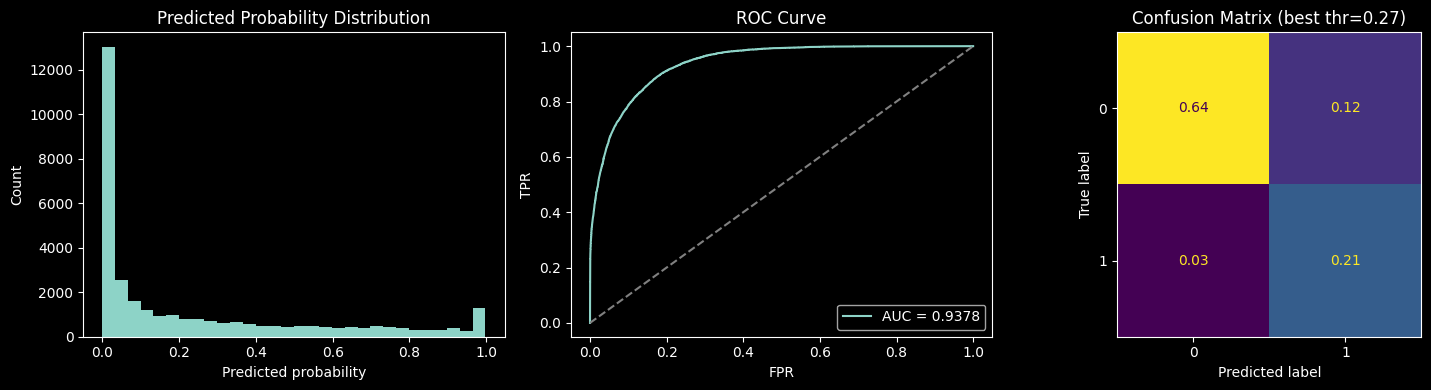

In [13]:
del auc
from sklearn.metrics import auc

# ==========================
# FE適用データ
# ==========================
X_fe = X.copy()
X_fe["capital-loss_log"] = np.log1p(X_fe["capital-loss"])
X_fe["capital-loss_sq"]  = X_fe["capital-loss"] ** 2

# ==========================
# モデル学習
# ==========================
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(
    X_fe, y_np, test_size=0.2, random_state=42, stratify=y_np
)

model = train_model(X_train_lgb, y_train_lgb, X_valid_lgb, y_valid_lgb)

# ==========================
# 予測確率と正解ラベル
# ==========================
p = model.predict_proba(X_fe)[:, 1]
y_true = y_np

# ==========================
# ROC計算
# ==========================
fpr, tpr, thresholds = roc_curve(y_true, p)
roc_auc = auc(fpr, tpr)

# ==========================
# 最適閾値（左上最短距離）
# ==========================
dist = ((fpr**2) + (1 - tpr)**2)**0.5
best_idx = dist.argmin()
best_thr = thresholds[best_idx]

# ==========================
# Confusion Matrix
# ==========================
y_pred = (p >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum()

# ==========================
# 1セル3図
# ==========================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(p, bins=30)
axes[0].set_title("Predicted Probability Distribution")
axes[0].set_xlabel("Predicted probability")
axes[0].set_ylabel("Count")

axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].legend()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1])
disp.plot(ax=axes[2], values_format=".2f", colorbar=False)
axes[2].set_title(f"Confusion Matrix (best thr={best_thr:.2f})")

plt.tight_layout()
plt.show()


ベースラインモデルと有力FE候補モデルの可視化結果を比較した。

ROC Curve によるAUCは、
ベースライン 0.9407 に対し、FE導入モデルは 0.9378 と、
約0.0029の低下が確認された。

予測確率ヒストグラムでは、
分布形状に有意な差は認められず、
確率出力構造の改善は確認されなかった。

Confusion Matrix 比較では、
全体正解率および誤分類バランスに顕著な変化は見られなかった。

以上より、本FE候補は
分類性能の改善には寄与せず、
性能指標上はベースライン比で微小な悪化を示した。

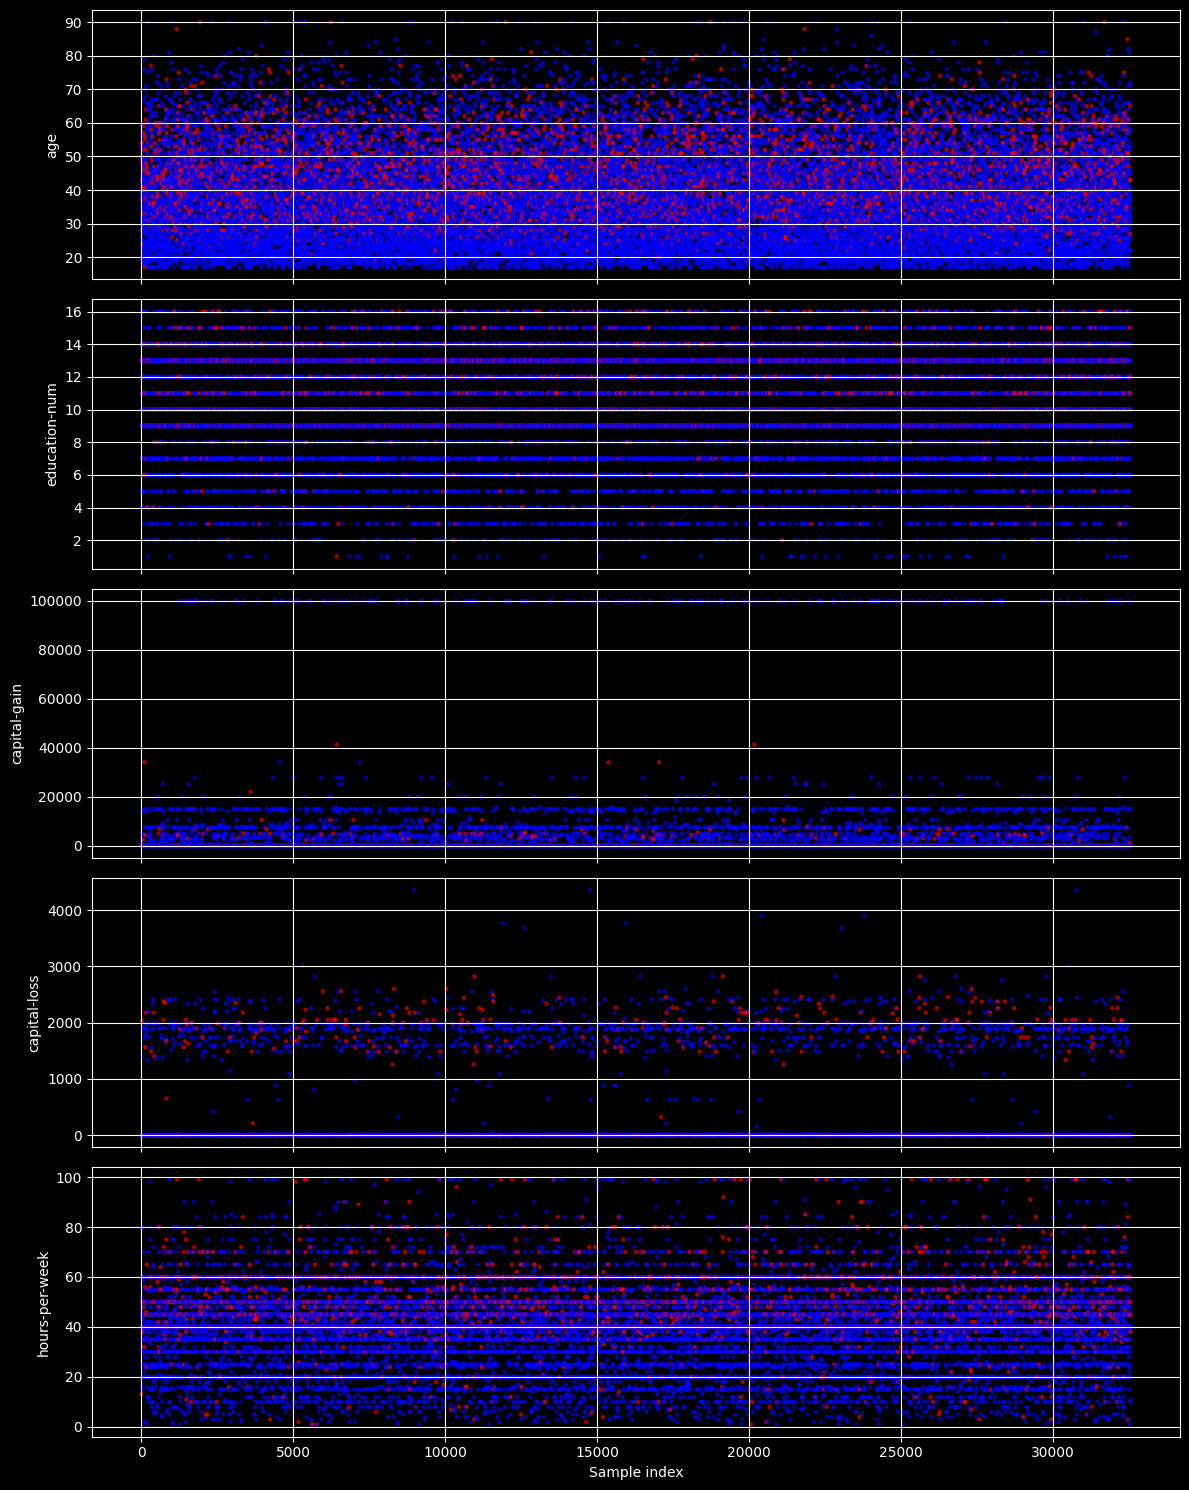

In [14]:
# ==========================
# 予測ラベルと正誤判定
# ==========================
threshold = 0.26
y_pred = (model.predict_proba(X_fe)[:, 1] >= threshold).astype(int)

# 正誤フラグ
correct = (y_pred == y_np)

NUM_COLS = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
X_num = X_fe[NUM_COLS]

# ==========================
# インデックス散布図
# ==========================
fig, axes = plt.subplots(len(NUM_COLS), 1, figsize=(12, 3 * len(NUM_COLS)), sharex=True)

if len(NUM_COLS) == 1:
    axes = [axes]

for i, col in enumerate(NUM_COLS):
    colors = np.where(correct, "blue", "red")

    axes[i].scatter(
        X_num.index,
        X_num[col],
        c=colors,
        s=5,
        alpha=0.5
    )
    axes[i].set_ylabel(col)
    axes[i].grid(True)

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()


ベースラインモデルとFE導入モデルのNUM_COLS散布図を比較した。

誤分類分布（赤点）の位置および密度は、
両モデル間で明確な変化を示さなかった。

age では、誤分類は両モデルとも全域に散在し、
集中帯域の変化は確認されなかった。

education-num でも、
低〜中位値域における誤分類構造は共通して観察された。

capital-gain / capital-loss では、
ゼロ集中領域および中間値域の誤分類分布に顕著な差は見られなかった。

hours-per-week についても、
誤分類の発生帯域・散在傾向はほぼ同様であった。

以上より、FE導入による
誤分類分布構造の有意な改善は確認されなかった。

## 6. 考察

1．FEの効果

本フェーズでは、単調変換（log1p）、フラグ特徴量、交互作用（積）、複合変換（log + 二乗）を検証した。

評価指標AUCの観点では、
安定的な性能改善は確認されなかった。

観測された変化はいずれも微小であり、クロスバリデーションのばらつき範囲内であった。

2．構造的解釈

PCA分析では、

- 寄与率に極端な偏りなし
- 負荷量の解釈可能
- 不自然な固有値構造なし

という結果であり、特徴量空間の基本構造は概ね安定していた。

また、検証したFEの多くは既存情報の再表現または単調変換に該当し、決定境界へ本質的変化を与えにくい性質を持つ。交互作用項についても、元特徴量の線形分離性が高い場合には寄与が限定的となる。

3．本フェーズの結論と示唆

本結果は「改善が得られなかった」という否定的結論ではなく、

「本条件下では既存特徴量で識別構造が概ね説明されていた」

という結果として解釈される。

性能改善に至らなかったFEについても、特徴量構造の理解および探索戦略の見直しに有用な知見を与えた。特に、単調変換および単純交互作用の効果が限定的であった点は、今後のFE設計方針に示唆を与える。